<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Supervised%20Learning/Neural%20Network/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
class ProcrastinationPredictor:
    def __init__(self, random_state=42):
        """Initialize the procrastination predictor model"""
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.model = None
        self.history = None
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

    def preprocess_data(self, X, y, test_size=0.2, val_size=0.2):
        """
        Preprocess data and split into train/val/test sets

        Args:
            X: Feature matrix (numpy array or pandas DataFrame)
            y: Target vector (numpy array or pandas Series)
            test_size: Proportion for test set
            val_size: Proportion for validation set (of remaining data after test split)

        Returns:
            X_train, X_val, X_test, y_train, y_val, y_test
        """
        # First split into train+val and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state)

        # Then split train+val into train and val
        val_size_adj = val_size / (1 - test_size)  # Adjust for previous split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adj, random_state=self.random_state)

        # Standardize features
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        X_val = self.scaler.transform(X_val)
        X_test = self.scaler.transform(X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test

    def build_model(self, input_shape, l2_reg=0.01, dropout_rate=0.3):
        """Build the neural network architecture"""
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape,
                  kernel_regularizer=l2(l2_reg)),
            BatchNormalization(),
            Dropout(dropout_rate),

            Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
            BatchNormalization(),
            Dropout(dropout_rate/2),

            Dense(16, activation='relu'),
            BatchNormalization(),

            Dense(1)
        ])

        model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae'])

        return model

    def train(self, X_train, y_train, X_val=None, y_val=None,
              epochs=200, batch_size=32, patience=20):
        """
        Train the neural network model

        Args:
            X_train: Training features
            y_train: Training target
            X_val: Validation features (optional)
            y_val: Validation target (optional)
            epochs: Maximum number of training epochs
            batch_size: Batch size for training
            patience: Patience for early stopping

        Returns:
            Training history
        """
        if self.model is None:
            self.model = self.build_model(input_shape=(X_train.shape[1],))

        callbacks = []
        if X_val is not None and y_val is not None:
            callbacks.append(
                EarlyStopping(monitor='val_loss', patience=patience,
                             restore_best_weights=True)
            )
            validation_data = (X_val, y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate model performance on test set"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        y_pred = self.model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        return {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'predictions': y_pred,
            'true_values': y_test
        }

    def feature_importance(self, X, y, n_repeats=10, metric=mean_squared_error):
        """Calculate permutation feature importance"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        def scorer(estimator, X, y):
            return metric(y, estimator.predict(X).flatten())

        result = permutation_importance(
            self.model, X, y,
            n_repeats=n_repeats,
            random_state=self.random_state,
            scoring=scorer
        )

        return result

    def predict(self, X):
        """Make predictions on new data"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled).flatten()

    def plot_history(self):
        """Plot training history"""
        if self.history is None:
            raise ValueError("Model has not been trained yet")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss (MSE)')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Train MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [10]:
# import data
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)
li1 = li[['conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'depersonalization_composite',
    'workaholism_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite',
    'procrastination_composite'
]].copy()

predictor = li1[[
    'conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite'
]]
target = li1['procrastination_composite']

X = predictor
y = target

Training model...
Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 237.2453 - mae: 13.6069 - val_loss: 262.7954 - val_mae: 14.6633
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 233.5804 - mae: 13.5864 - val_loss: 261.8576 - val_mae: 14.6392
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 229.8347 - mae: 13.5660 - val_loss: 260.8701 - val_mae: 14.6136
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 227.6548 - mae: 13.5457 - val_loss: 260.0580 - val_mae: 14.5925
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 225.0666 - mae: 13.5254 - val_loss: 259.2024 - val_mae: 14.5708
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 220.2095 - mae: 13.5050 - val_loss: 258.3344 - val_mae: 14.5480
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 220.3313 - mae: 13.4846 - val_loss: 257.3962 - val_mae: 14.5232
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 219.2935 - mae: 13.4642 - val_loss: 256.4079 - val_mae: 14.4969
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━

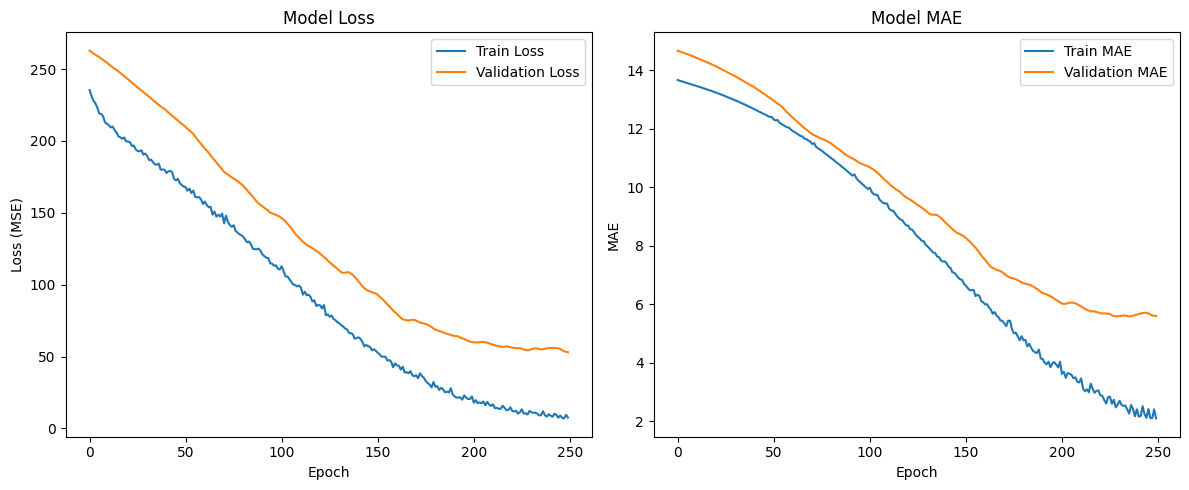

In [11]:
# STEP 3: Initialize and preprocess data
predictor = ProcrastinationPredictor(random_state=42)
X_train, X_val, X_test, y_train, y_val, y_test = predictor.preprocess_data(
    X, y, test_size=0.15, val_size=0.15)

# STEP 4: Train the model
print("Training model...")
history = predictor.train(X_train, y_train, X_val, y_val, epochs=250)

# STEP 5: Evaluate the model
results = predictor.evaluate(X_test, y_test)
print("\nTest Set Performance:")
print(f"MSE: {results['mse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"RMSE: {results['rmse']:.4f}")

# STEP 6: Visualize training history
predictor.plot_history()

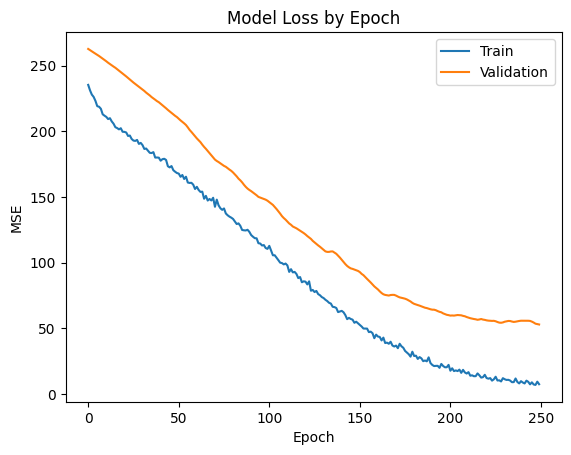

In [12]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss by Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

epoch = 250 seems like a good choice.

In [14]:
# STEP 7: Check feature importance
importance = predictor.feature_importance(X_test, y_test)
print("\nFeature Importance (higher = more important):")

# Make sure 'predictors' contains your feature names
predictors = [
    'conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite'
]

for i, feature_name in enumerate(predictors):
    print(f"{feature_name}: {importance.importances_mean[i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━

In [15]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictor.predict(X_test))
print(f"Variance explained (R²): {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Variance explained (R²): -1.07


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


this is weird...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


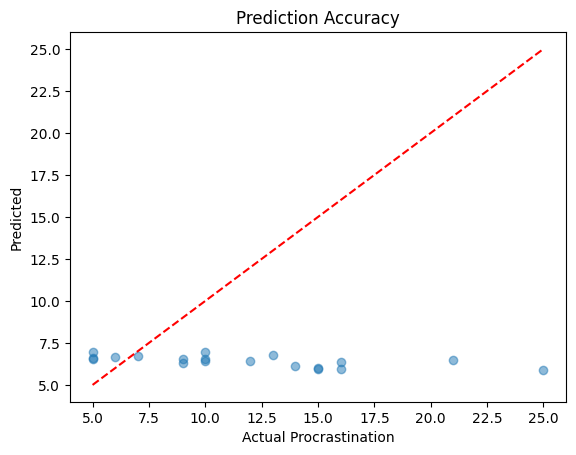

In [16]:
plt.scatter(y_test, predictor.predict(X_test), alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Procrastination')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')
plt.show()